In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
sns.set_style('whitegrid')
import tensorflow as tf
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
import time
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

In [2]:
SMALL_SIZE = 10
MEDIUM_SIZE = 12

plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=MEDIUM_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rcParams['figure.dpi']=150

In [3]:
#load data
sdss_df = pd.read_csv('Skyserver_SQL2_27_2018 6_51_39 PM.csv', skiprows=0)

In [4]:
#First look at dataset
sdss_df.head()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1.237650e+18,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,752,301,4,267,3.722360e+18,STAR,-0.000009,3306,54922,491
1,1.237650e+18,183.598370,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,752,301,4,267,3.638140e+17,STAR,-0.000055,323,51615,541
2,1.237650e+18,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,752,301,4,268,3.232740e+17,GALAXY,0.123111,287,52023,513
3,1.237650e+18,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,752,301,4,269,3.722370e+18,STAR,-0.000111,3306,54922,510
4,1.237650e+18,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,752,301,4,269,3.722370e+18,STAR,0.000590,3306,54922,512


In [5]:
#Types of columns
sdss_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   objid      10000 non-null  float64
 1   ra         10000 non-null  float64
 2   dec        10000 non-null  float64
 3   u          10000 non-null  float64
 4   g          10000 non-null  float64
 5   r          10000 non-null  float64
 6   i          10000 non-null  float64
 7   z          10000 non-null  float64
 8   run        10000 non-null  int64  
 9   rerun      10000 non-null  int64  
 10  camcol     10000 non-null  int64  
 11  field      10000 non-null  int64  
 12  specobjid  10000 non-null  float64
 13  class      10000 non-null  object 
 14  redshift   10000 non-null  float64
 15  plate      10000 non-null  int64  
 16  mjd        10000 non-null  int64  
 17  fiberid    10000 non-null  int64  
dtypes: float64(10), int64(7), object(1)
memory usage: 1.4+ MB


In [6]:
sdss_df.describe()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,redshift,plate,mjd,fiberid
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.0,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.237650e+18,175.529987,14.836148,18.619355,17.371931,16.840963,16.583579,16.422833,981.034800,301.0,3.648700,302.380100,1.645022e+18,0.143726,1460.986400,52943.533300,353.069400
std,0.000000e+00,47.783439,25.212207,0.828656,0.945457,1.067764,1.141805,1.203188,273.305024,0.0,1.666183,162.577763,2.013998e+18,0.388774,1788.778371,1511.150651,206.298149
min,1.237650e+18,8.235100,-5.382632,12.988970,12.799550,12.431600,11.947210,11.610410,308.000000,301.0,1.000000,11.000000,2.995780e+17,-0.004136,266.000000,51578.000000,1.000000
25%,1.237650e+18,157.370946,-0.539035,18.178035,16.815100,16.173333,15.853705,15.618285,752.000000,301.0,2.000000,184.000000,3.389248e+17,0.000081,301.000000,51900.000000,186.750000
50%,1.237650e+18,180.394514,0.404166,18.853095,17.495135,16.858770,16.554985,16.389945,756.000000,301.0,4.000000,299.000000,4.966580e+17,0.042591,441.000000,51997.000000,351.000000
75%,1.237650e+18,201.547279,35.649397,19.259232,18.010145,17.512675,17.258550,17.141447,1331.000000,301.0,5.000000,414.000000,2.881300e+18,0.092579,2559.000000,54468.000000,510.000000
max,1.237650e+18,260.884382,68.542265,19.599900,19.918970,24.802040,28.179630,22.833060,1412.000000,301.0,6.000000,768.000000,9.468830e+18,5.353854,8410.000000,57481.000000,1000.000000


In [7]:
sdss_df['class'].value_counts()

GALAXY    4998
STAR      4152
QSO        850
Name: class, dtype: int64

In [8]:
print('Columns(features) names:')
sdss_df.columns.values

Columns(features) names:


array(['objid', 'ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'run', 'rerun',
       'camcol', 'field', 'specobjid', 'class', 'redshift', 'plate',
       'mjd', 'fiberid'], dtype=object)

In [9]:
#Drop the columns(fatures) that are unlikely to be related to the target variable 'class'
sdss_df.drop(['objid', 'run', 'rerun', 'camcol', 'field', 'specobjid'], axis = 1, inplace = True)
sdss_df.head()

,ra,dec,u,g,r,i,z,class,redshift,plate,mjd,fiberid
0,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,STAR,-0.000009,3306,54922,491
1,183.598370,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,STAR,-0.000055,323,51615,541
2,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,GALAXY,0.123111,287,52023,513
3,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,STAR,-0.000111,3306,54922,510
4,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,STAR,0.000590,3306,54922,512


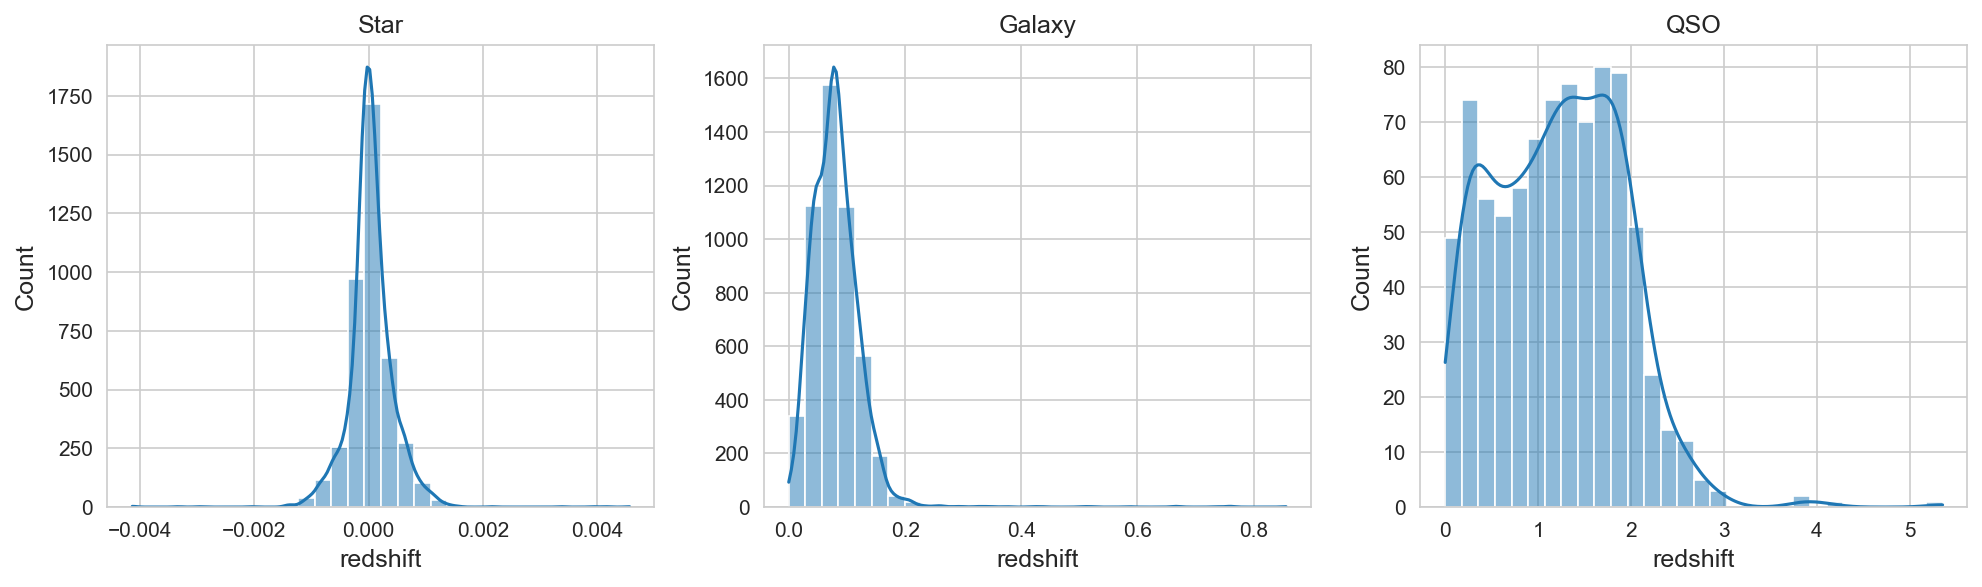

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 4))
sns.histplot(sdss_df[sdss_df['class']=='STAR'].redshift, bins = 30, kde = True, ax = axes[0])
axes[0].set_title('Star')
sns.histplot(sdss_df[sdss_df['class']=='GALAXY'].redshift, bins = 30, kde = True, ax = axes[1])
axes[1].set_title('Galaxy')
sns.histplot(sdss_df[sdss_df['class']=='QSO'].redshift, bins = 30, kde = True, ax = axes[2])
axes[2].set_title('QSO')
plt.savefig('redshift_hist.png')
plt.show()

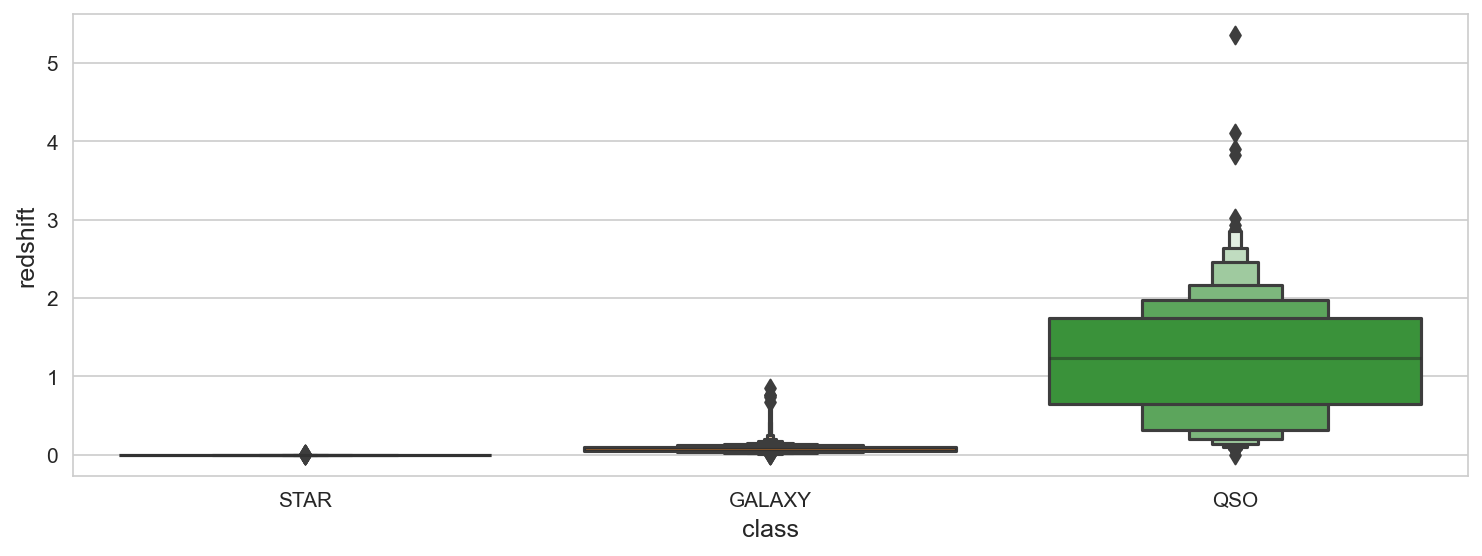

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(12, 4))
ax = sns.boxenplot(x=sdss_df['class'], y=sdss_df['redshift'])
plt.savefig('redshift_boxen_plot.png')

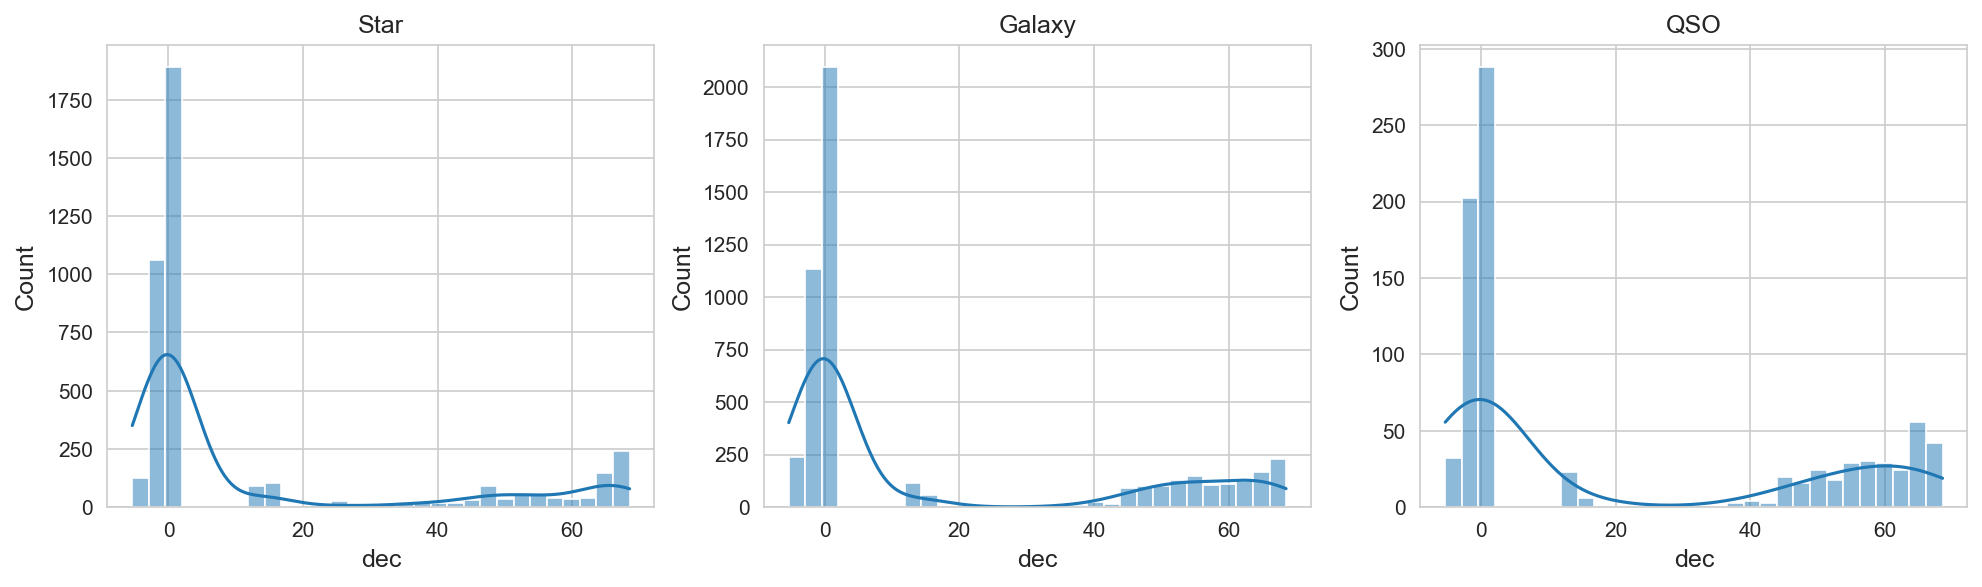

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 4))
sns.histplot(sdss_df[sdss_df['class']=='STAR'].dec, bins = 30, kde = True, ax = axes[0])
axes[0].set_title('Star')
sns.histplot(sdss_df[sdss_df['class']=='GALAXY'].dec, bins = 30, kde = True, ax = axes[1])
axes[1].set_title('Galaxy')
sns.histplot(sdss_df[sdss_df['class']=='QSO'].dec, bins = 30, kde = True, ax = axes[2])
axes[2].set_title('QSO')
plt.savefig('dec_hist.png')
plt.show()

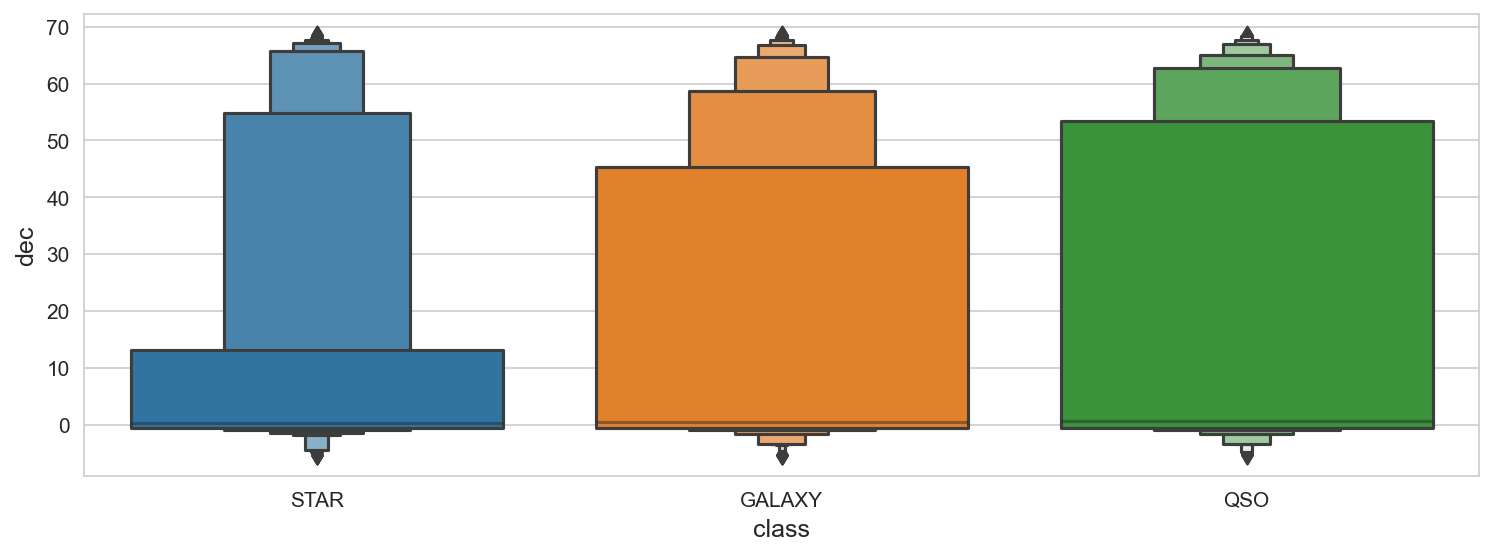

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(12, 4))
ax = sns.boxenplot(x=sdss_df['class'], y=sdss_df['dec'])
plt.savefig('dec_boxen_plot.png')

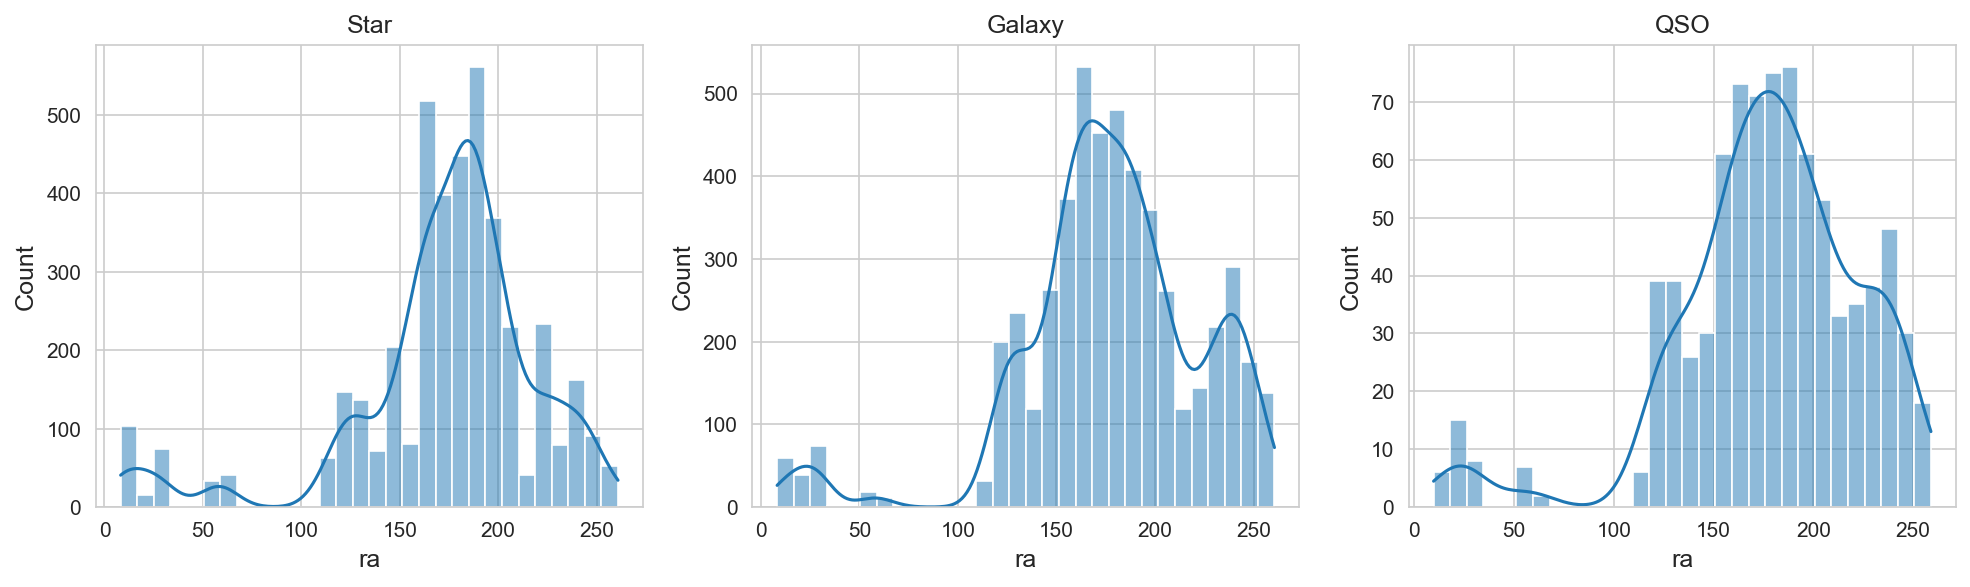

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 4))
sns.histplot(sdss_df[sdss_df['class']=='STAR'].ra, bins = 30, kde = True, ax = axes[0])
axes[0].set_title('Star')
sns.histplot(sdss_df[sdss_df['class']=='GALAXY'].ra, bins = 30, kde = True, ax = axes[1])
axes[1].set_title('Galaxy')
sns.histplot(sdss_df[sdss_df['class']=='QSO'].ra, bins = 30, kde = True, ax = axes[2])
axes[2].set_title('QSO')
plt.savefig('ra_hist.png')
plt.show()

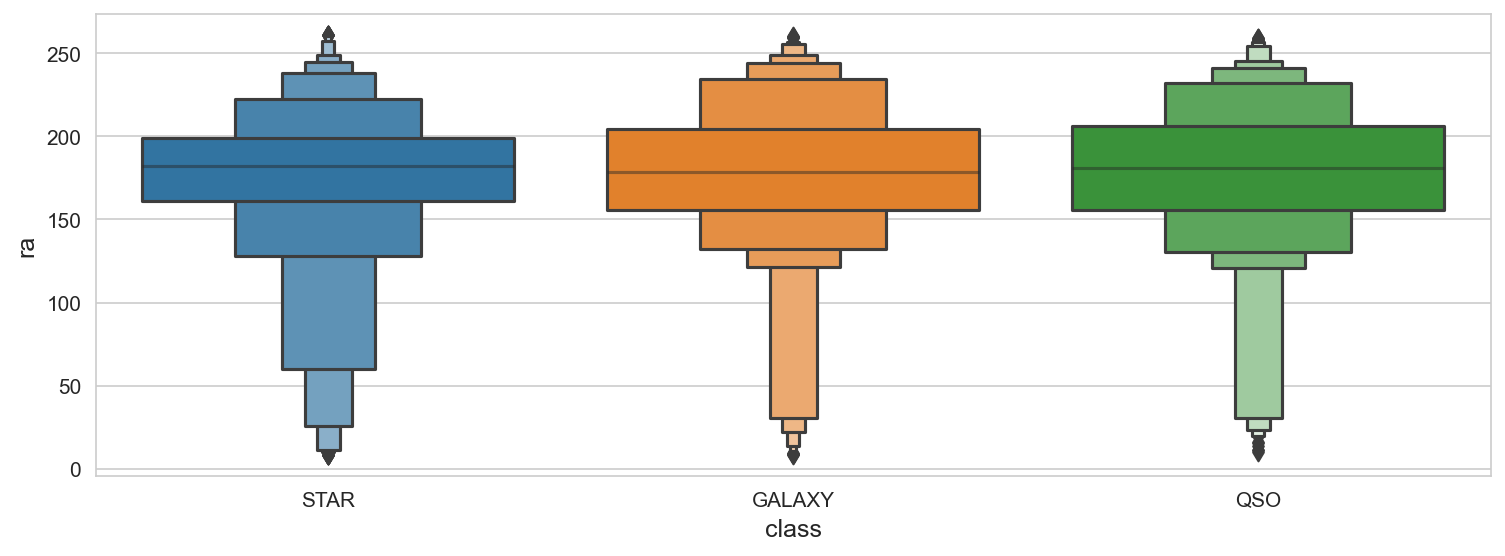

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(12, 4))
ax = sns.boxenplot(x=sdss_df['class'], y=sdss_df['ra'])

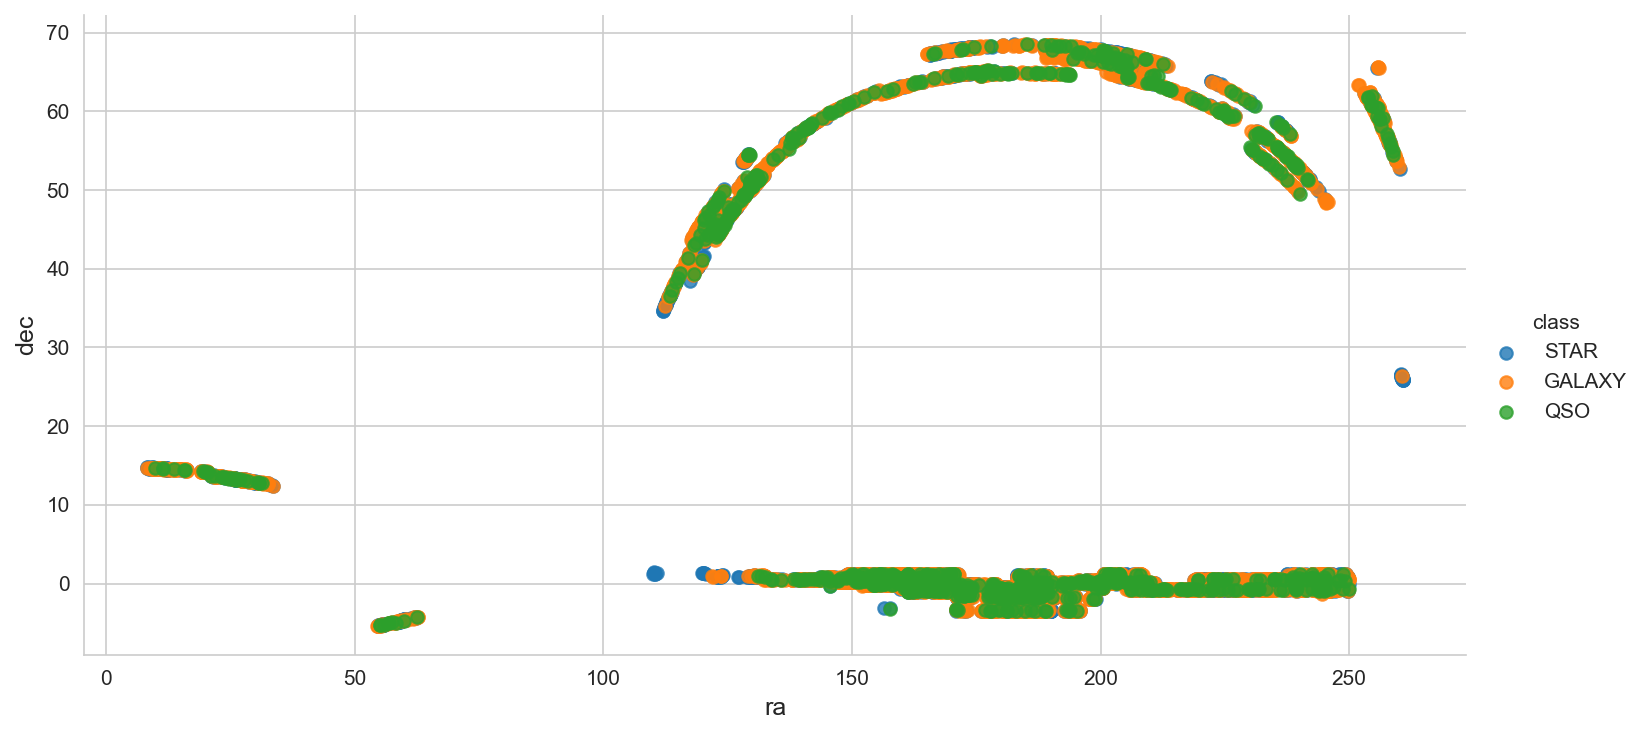

In [16]:
sns.lmplot(x='ra', y='dec', data=sdss_df, hue='class', fit_reg=False, aspect=2)
#plt.title('Equatorial coordinates')
plt.savefig('ra i dec.png')

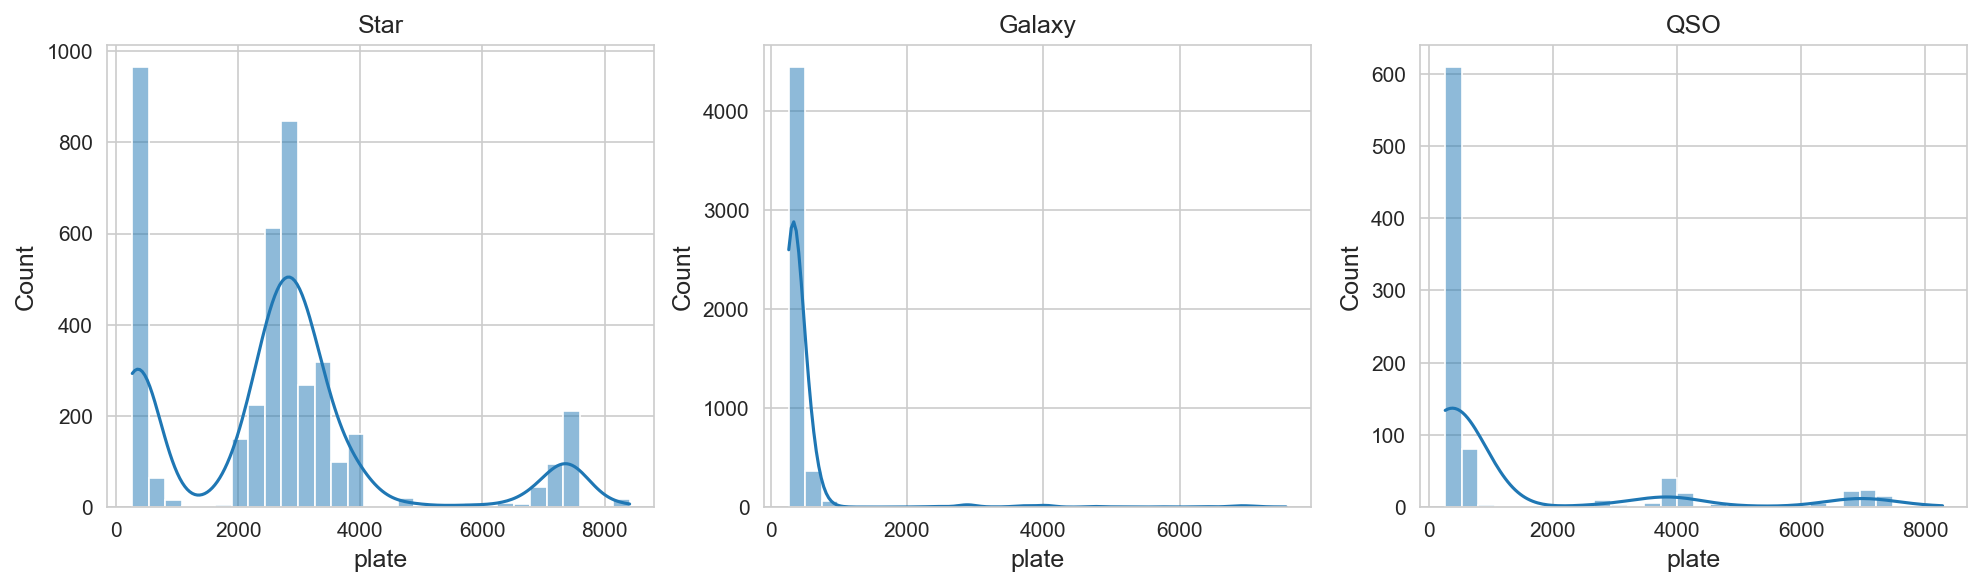

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 4))
sns.histplot(sdss_df[sdss_df['class']=='STAR'].plate, bins = 30, kde = True, ax = axes[0])
axes[0].set_title('Star')
sns.histplot(sdss_df[sdss_df['class']=='GALAXY'].plate, bins = 30, kde = True, ax = axes[1])
axes[1].set_title('Galaxy')
sns.histplot(sdss_df[sdss_df['class']=='QSO'].plate, bins = 30, kde = True, ax = axes[2])
axes[2].set_title('QSO')
plt.savefig('plate_hist.png')
plt.show()

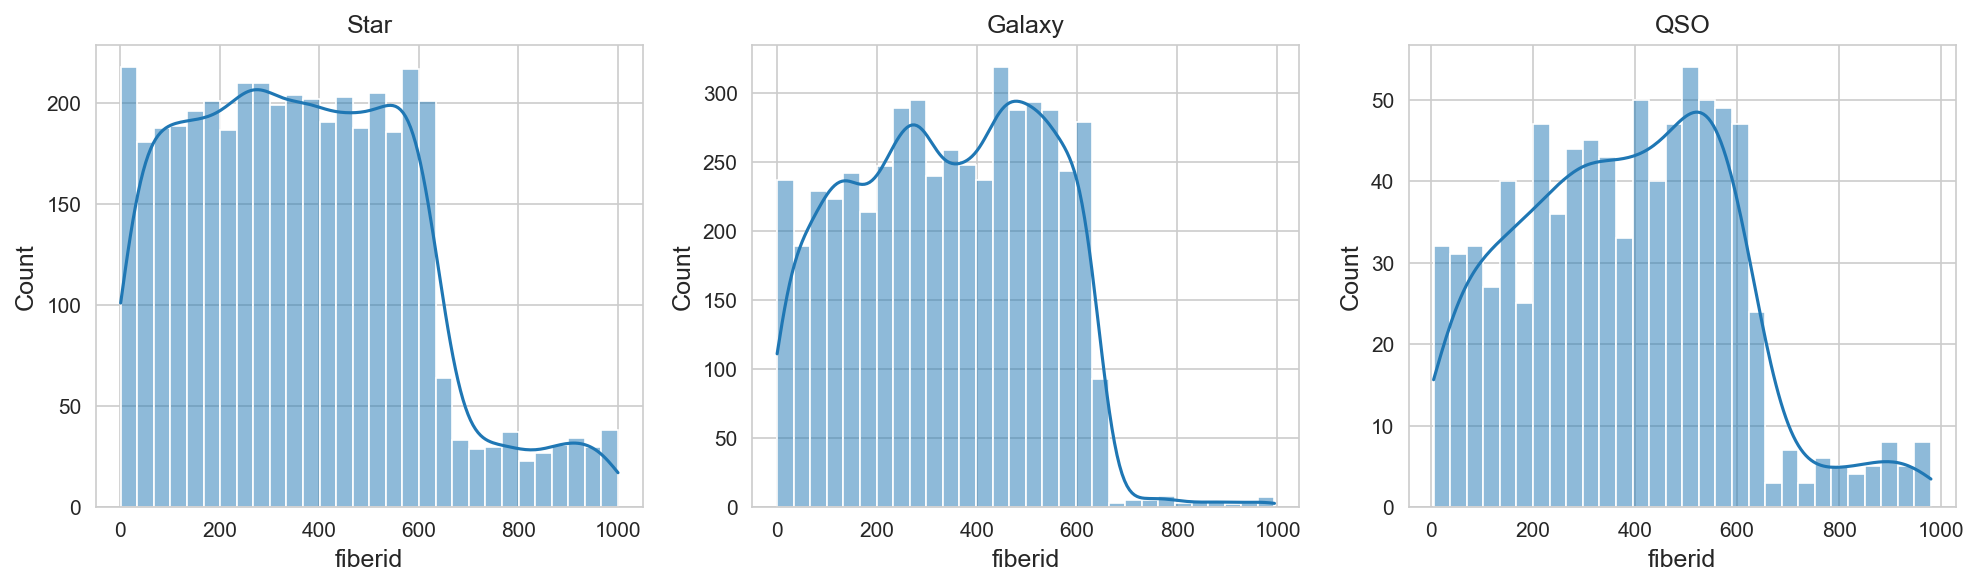

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 4))
sns.histplot(sdss_df[sdss_df['class']=='STAR'].fiberid, bins = 30, kde = True, ax = axes[0])
axes[0].set_title('Star')
sns.histplot(sdss_df[sdss_df['class']=='GALAXY'].fiberid, bins = 30, kde = True, ax = axes[1])
axes[1].set_title('Galaxy')
sns.histplot(sdss_df[sdss_df['class']=='QSO'].fiberid, bins = 30, kde = True, ax = axes[2])
axes[2].set_title('QSO')
plt.savefig('fiberid_hist.png')
plt.show()

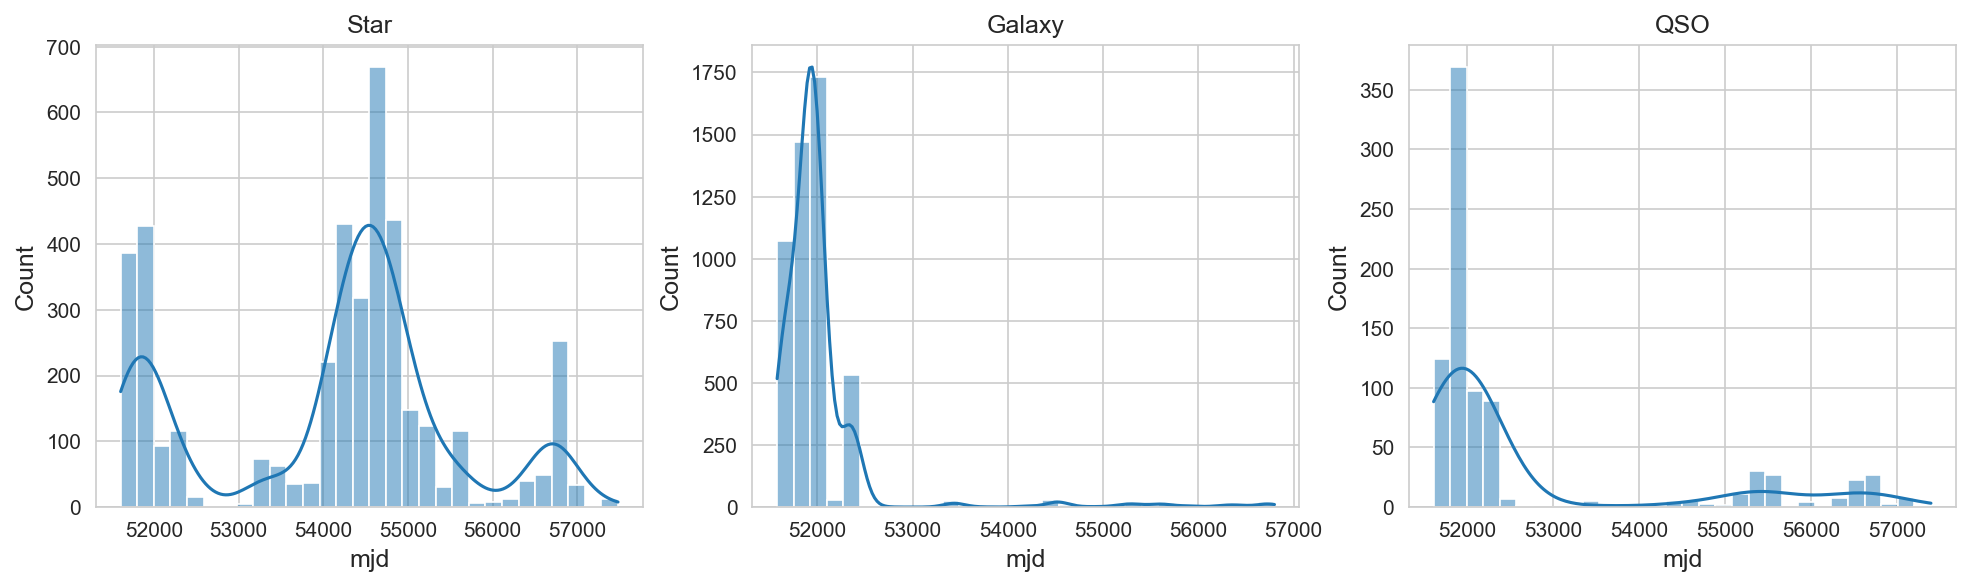

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 4))
sns.histplot(sdss_df[sdss_df['class']=='STAR'].mjd, bins = 30, kde = True, ax = axes[0])
axes[0].set_title('Star')
sns.histplot(sdss_df[sdss_df['class']=='GALAXY'].mjd, bins = 30, kde = True, ax = axes[1])
axes[1].set_title('Galaxy')
sns.histplot(sdss_df[sdss_df['class']=='QSO'].mjd, bins = 30, kde = True, ax = axes[2])
axes[2].set_title('QSO')
plt.savefig('mjd_hist.png')
plt.show()

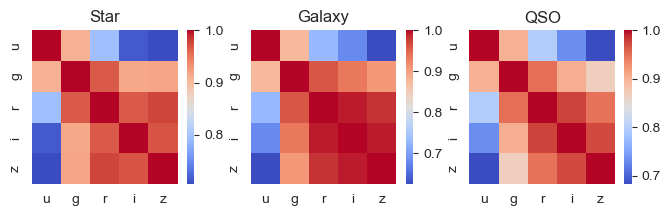

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(8, 2))
fig.set_dpi(100)
ax = sns.heatmap(sdss_df[sdss_df['class']=='STAR'][['u', 'g', 'r', 'i', 'z']].corr(), ax = axes[0], cmap='coolwarm')
ax.set_title('Star')
ax = sns.heatmap(sdss_df[sdss_df['class']=='GALAXY'][['u', 'g', 'r', 'i', 'z']].corr(), ax = axes[1], cmap='coolwarm')
ax.set_title('Galaxy')
ax = sns.heatmap(sdss_df[sdss_df['class']=='QSO'][['u', 'g', 'r', 'i', 'z']].corr(), ax = axes[2], cmap='coolwarm')
ax = ax.set_title('QSO')
plt.savefig('ugriz.png')

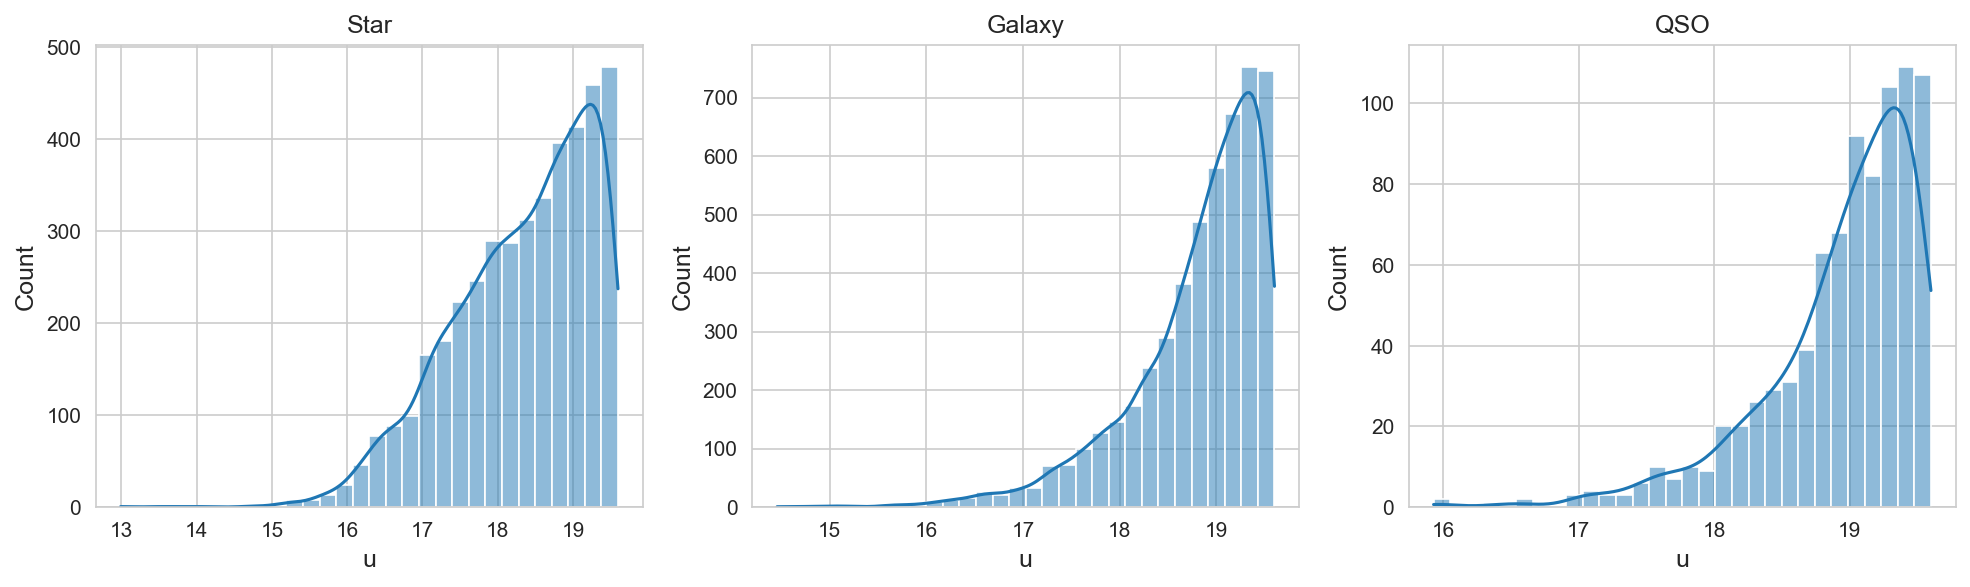

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 4))
sns.histplot(sdss_df[sdss_df['class']=='STAR'].u, bins = 30, kde = True, ax = axes[0])
axes[0].set_title('Star')
sns.histplot(sdss_df[sdss_df['class']=='GALAXY'].u, bins = 30, kde = True, ax = axes[1])
axes[1].set_title('Galaxy')
sns.histplot(sdss_df[sdss_df['class']=='QSO'].u, bins = 30, kde = True, ax = axes[2])
axes[2].set_title('QSO')
plt.show()

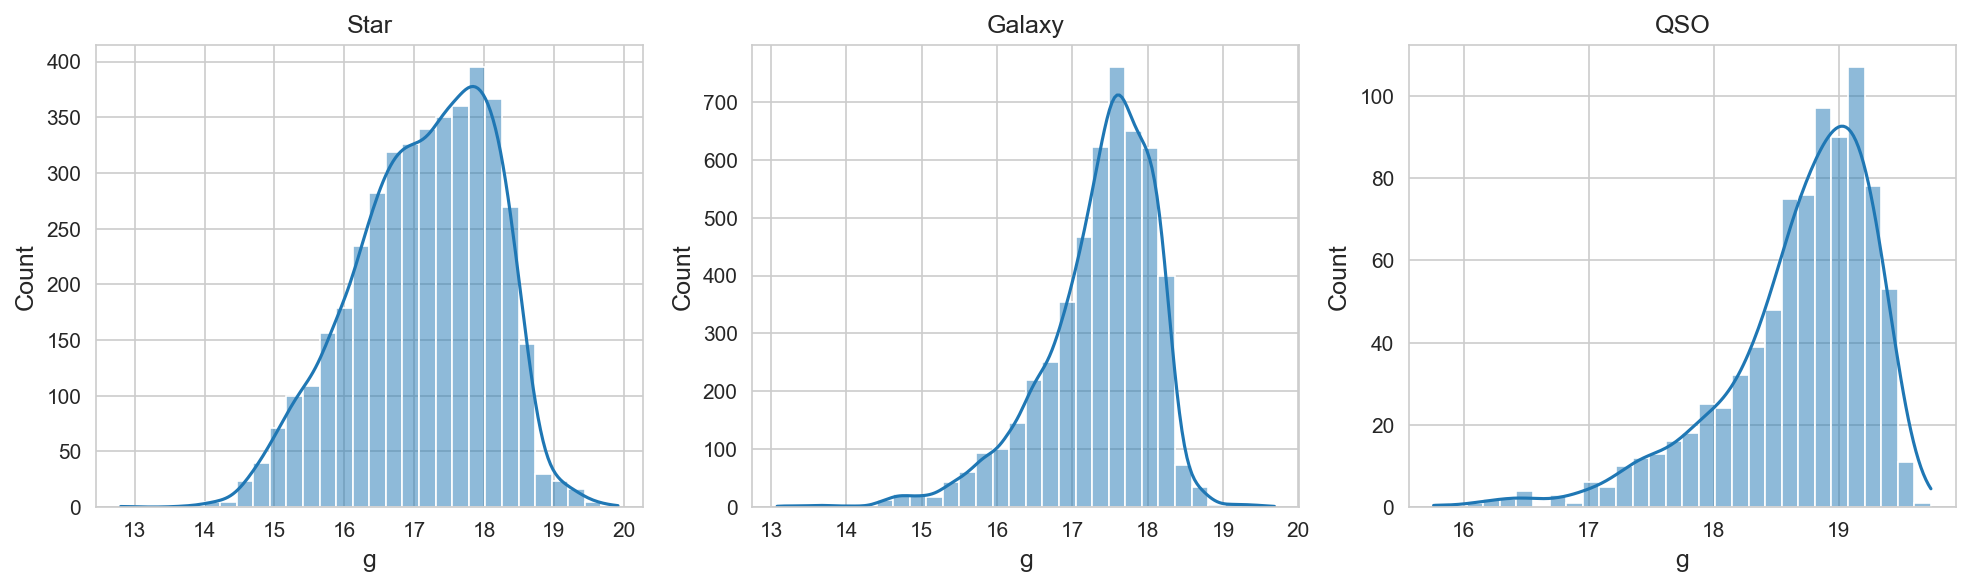

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 4))
sns.histplot(sdss_df[sdss_df['class']=='STAR'].g, bins = 30, kde = True, ax = axes[0])
axes[0].set_title('Star')
sns.histplot(sdss_df[sdss_df['class']=='GALAXY'].g, bins = 30, kde = True, ax = axes[1])
axes[1].set_title('Galaxy')
sns.histplot(sdss_df[sdss_df['class']=='QSO'].g, bins = 30, kde = True, ax = axes[2])
axes[2].set_title('QSO')
plt.show()

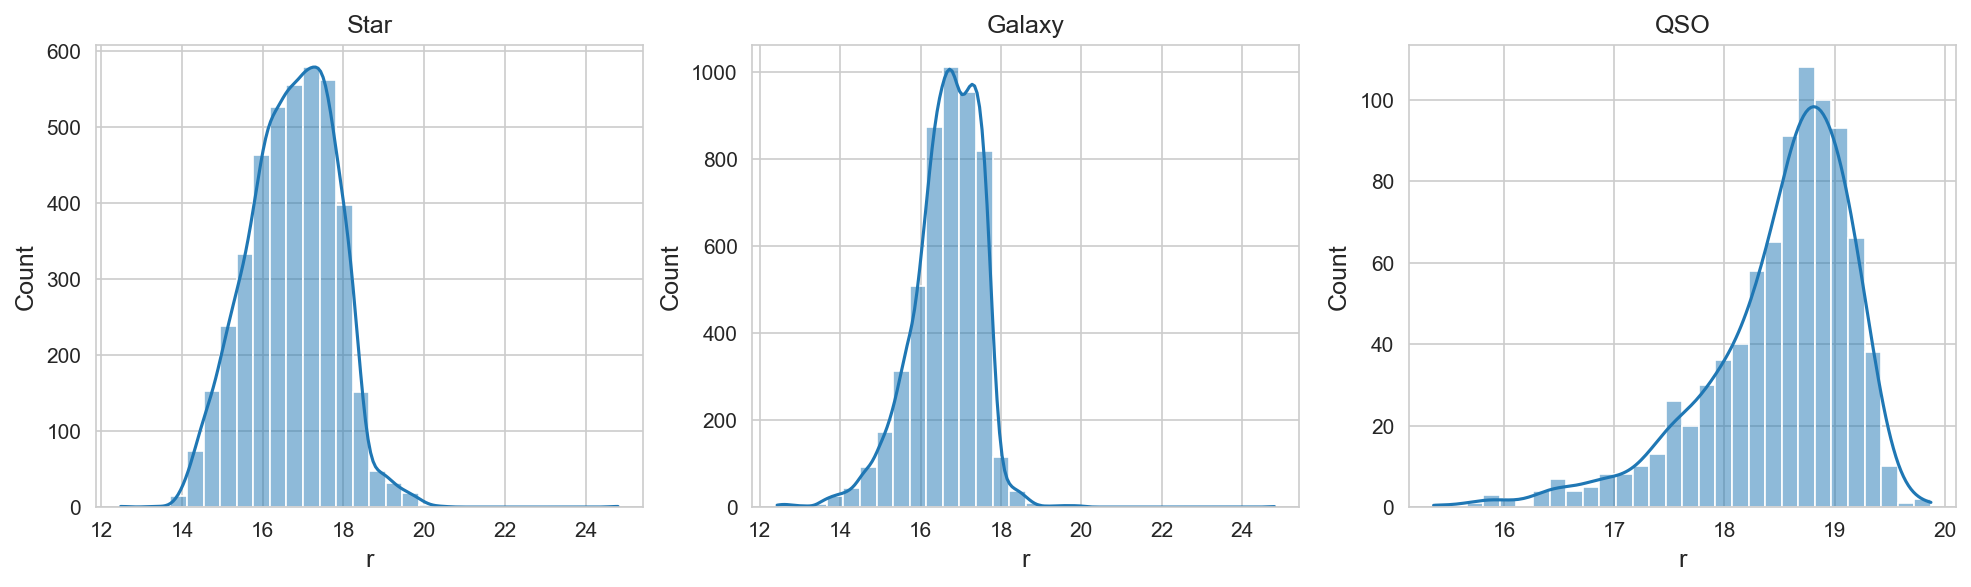

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 4))
sns.histplot(sdss_df[sdss_df['class']=='STAR'].r, bins = 30, kde = True, ax = axes[0])
axes[0].set_title('Star')
sns.histplot(sdss_df[sdss_df['class']=='GALAXY'].r, bins = 30, kde = True, ax = axes[1])
axes[1].set_title('Galaxy')
sns.histplot(sdss_df[sdss_df['class']=='QSO'].r, bins = 30, kde = True, ax = axes[2])
axes[2].set_title('QSO')
plt.show()

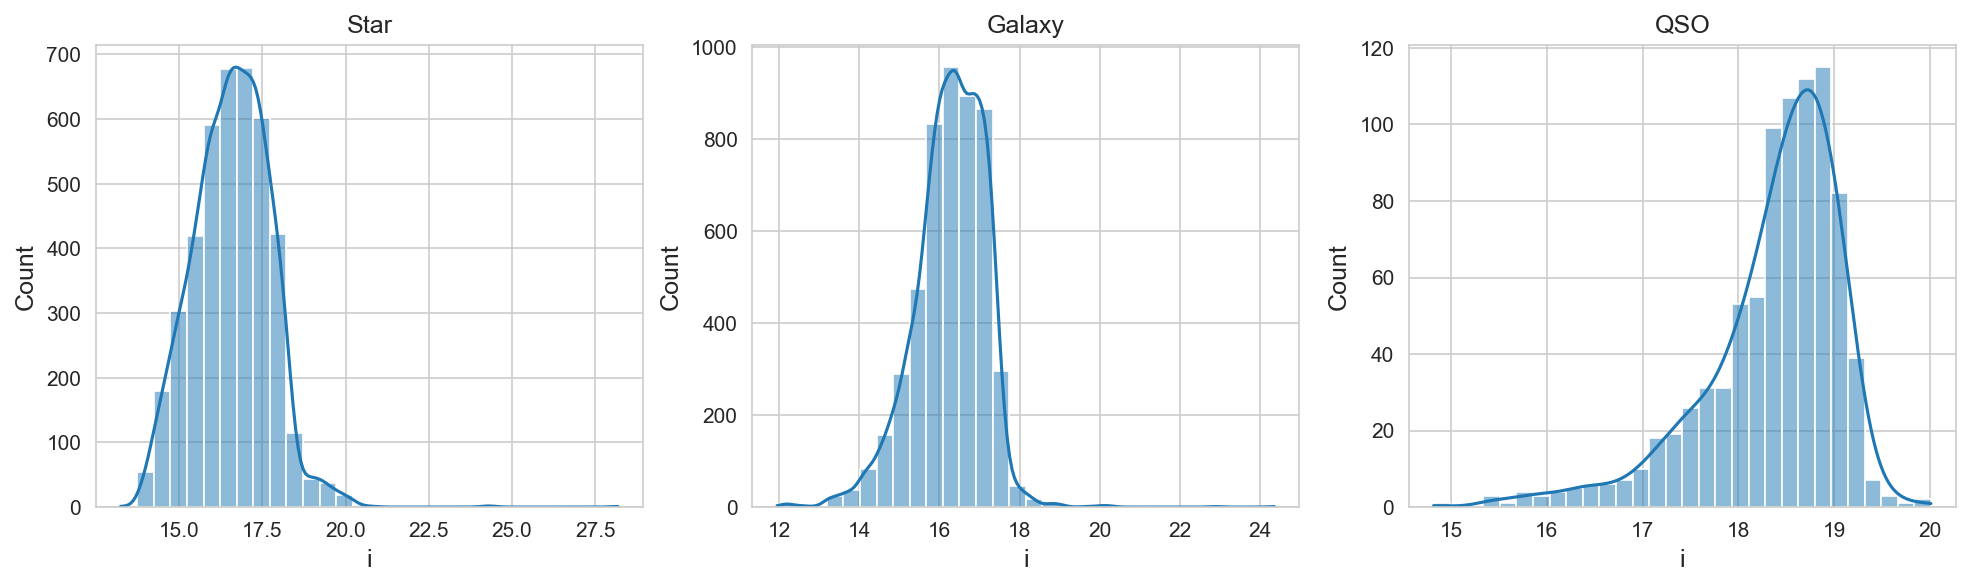

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 4))
sns.histplot(sdss_df[sdss_df['class']=='STAR'].i, bins = 30, kde = True, ax = axes[0])
axes[0].set_title('Star')
sns.histplot(sdss_df[sdss_df['class']=='GALAXY'].i, bins = 30, kde = True, ax = axes[1])
axes[1].set_title('Galaxy')
sns.histplot(sdss_df[sdss_df['class']=='QSO'].i, bins = 30, kde = True, ax = axes[2])
axes[2].set_title('QSO')
plt.show()

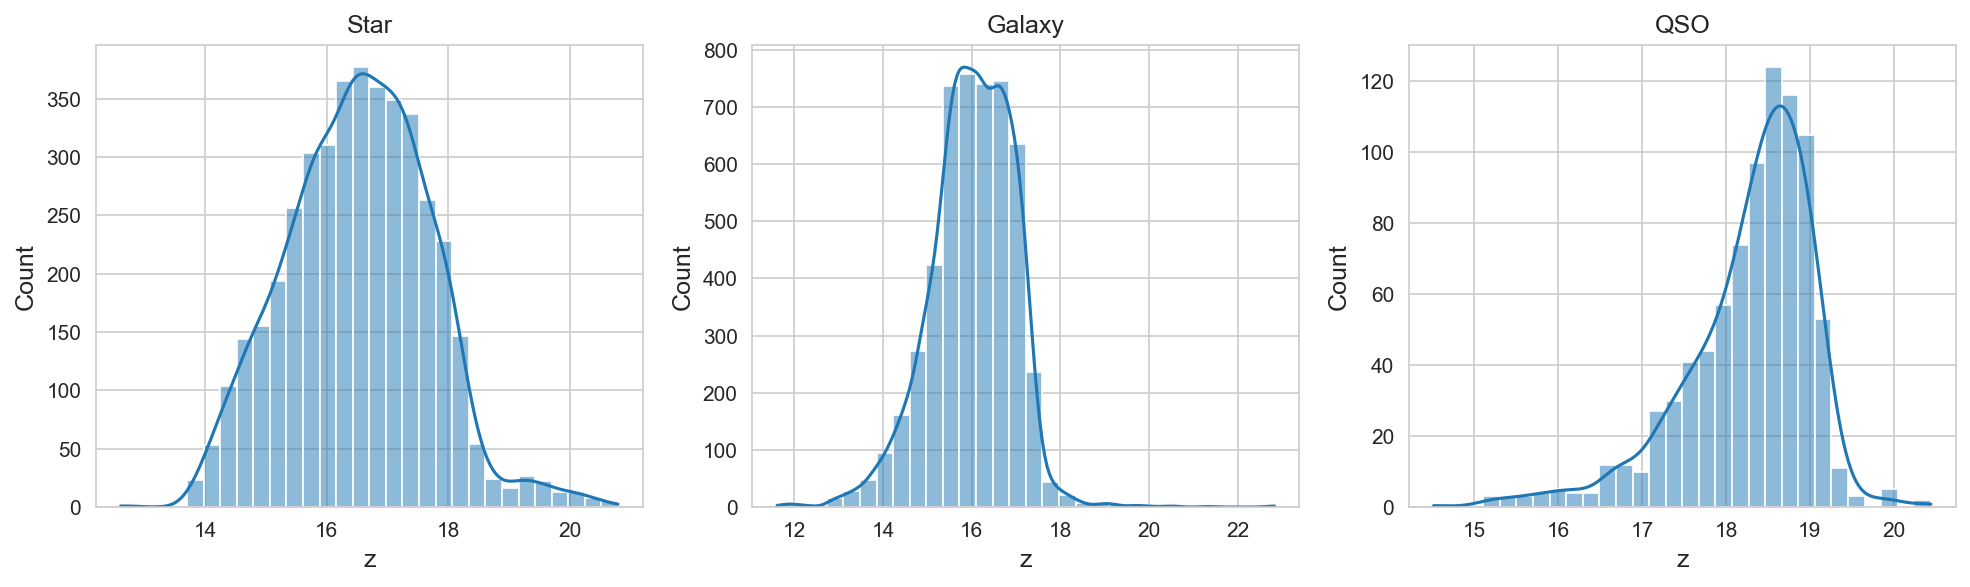

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 4))
sns.histplot(sdss_df[sdss_df['class']=='STAR'].z, bins = 30, kde = True, ax = axes[0])
axes[0].set_title('Star')
sns.histplot(sdss_df[sdss_df['class']=='GALAXY'].z, bins = 30, kde = True, ax = axes[1])
axes[1].set_title('Galaxy')
sns.histplot(sdss_df[sdss_df['class']=='QSO'].z, bins = 30, kde = True, ax = axes[2])
axes[2].set_title('QSO')
plt.show()

In [26]:
sdss_df_fe = sdss_df

# encode class labels to integers
le = LabelEncoder()
y_encoded = le.fit_transform(sdss_df_fe['class'])
sdss_df_fe['class'] = y_encoded

#Principal Component Analysis
pca = PCA(n_components=3)
ugriz = pca.fit_transform(sdss_df_fe[['u', 'g', 'r', 'i', 'z']])

# update dataframe 
sdss_df_fe = pd.concat((sdss_df_fe, pd.DataFrame(ugriz)), axis=1)
sdss_df_fe.rename({0: 'PCA_1', 1: 'PCA_2', 2: 'PCA_3'}, axis=1, inplace = True) 
sdss_df_fe.drop(['u', 'g', 'r', 'i', 'z'], axis=1, inplace=True)
sdss_df_fe.head()

,ra,dec,class,redshift,plate,mjd,fiberid,PCA_1,PCA_2,PCA_3
0,183.531326,0.089693,2,-0.000009,3306,54922,491,-1.507202,-1.377293,-0.265119
1,183.598370,0.135285,2,-0.000055,323,51615,541,-0.195758,-0.028410,-0.155695
2,183.680207,0.126185,0,0.123111,287,52023,513,1.297604,-0.590023,0.140338
3,183.870529,0.049911,2,-0.000111,3306,54922,510,-1.446117,0.566685,-0.009272
4,183.883288,0.102557,2,0.000590,3306,54922,512,-0.849271,1.287505,-0.397689


In [27]:
# feature scaling
scaler = MinMaxScaler()
sdss = scaler.fit_transform(sdss_df_fe.drop('class', axis = 1))

X_train, X_test, y_train, y_test = train_test_split(sdss, sdss_df_fe['class'], test_size = 0.2)

# Naive Bayes

In [29]:
gnb = GaussianNB()
scores = cross_val_score(gnb, X_train, y_train, cv=10, scoring = "accuracy")

print("Scores:", scores*100)
print("Mean:", scores.mean()*100)

acc_gnb = scores.mean()*100

Scores: [98.125 97.625 97.625 97.    97.125 98.25  98.625 96.875 98.    98.125]
Mean: 97.7375


# XGBoost

In [30]:
def tunningXGBoost(n_estimators):
    xgb = XGBClassifier(n_estimators = n_estimators)
    scores = cross_val_score(xgb, X_train, y_train, cv=3, scoring = "accuracy")
    return scores.mean()*100

In [31]:
number_of_estimators = [5, 10, 15, 20, 25, 30, 40, 50, 80, 100]
acc = []
acc_max = 0
for n in number_of_estimators:
    acc.append(tunningXGBoost(n))
    if acc_max < acc[-1]:
        acc_max = acc[-1]
        n_xgb_best = n
            
print(n_xgb_best, acc_max)

40 99.387520295897


In [32]:
xgb = XGBClassifier(n_estimators = n_xgb_best)
xgb.fit(X_train, y_train)

xgb = XGBClassifier(n_estimators = n_xgb_best)
scores = cross_val_score(xgb, X_train, y_train, cv=10, scoring = "accuracy")
print("Scores:", scores*100)
print("Mean:", scores.mean()*100)
acc_xgb = scores.mean()*100

Scores: [99.75  99.    99.375 99.25  98.5   99.    99.75  99.625 99.75  99.5  ]
Mean: 99.34999999999998


# Random Forest Classifier

In [33]:
def tunningRFC(n_estimators):
    rfc = RandomForestClassifier(n_estimators=n_estimators)
    
    scores = cross_val_score(rfc, X_train, y_train, cv=3, scoring = "accuracy")
    return scores.mean()*100

In [34]:
number_of_estimators = [5, 10, 20, 30, 40, 50, 80, 100]
acc = []
acc_max = 0
for n in number_of_estimators:
    acc.append(tunningRFC(n))
    if acc_max < acc[-1]:
        acc_max = acc[-1]
        n_rfc_best = n
            
print(n_rfc_best, acc_max)

50 99.21249997538753


In [35]:
rfc = RandomForestClassifier(n_estimators=n_rfc_best)
rfc.fit(X_train, y_train)

scores = cross_val_score(rfc, X_train, y_train, cv=10, scoring = "accuracy")
print("Scores:", scores*100)
print("Mean:", scores.mean()*100)
acc_rfc = scores.mean()*100

Scores: [99.625 99.    99.25  99.    98.75  99.    99.5   99.25  99.25  99.25 ]
Mean: 99.1875


# Support Vector Machine Classifier

In [36]:
def tunningSVC(c, kernel):
    svc = SVC(C = c, kernel = kernel)
    
    scores = cross_val_score(svc, X_train, y_train, cv=3, scoring = "accuracy")
    return scores.mean()*100

In [37]:
C = [1, 10, 30, 50, 80, 100, 200, 250, 300, 350]
kernel = ['linear', 'poly']
acc = []
acc_max = 1
for c in C:
    for k in kernel:
        acc.append(tunningSVC(c, k))
        if acc_max < acc[-1]:
            acc_max = acc[-1]
            best_c = c
            best_k = k
print(best_c, best_k, acc_max)
acc_svc = acc_max

350 poly 98.72497183163432


In [55]:
svc = SVC(C = best_c, kernel = best_k)
scores = cross_val_score(svc, X_train, y_train, cv=10, scoring = "accuracy")

print("Scores:", scores*100)
print("Mean:", scores.mean()*100)

acc_svc = scores.mean()*100

Scores: [99.25  99.375 99.125 98.625 99.    98.75  98.25  98.875 99.375 99.   ]
Mean: 98.96249999999999


In [56]:
results = pd.DataFrame({
    'Model':['Naive Bayes', 'XGBoost', 'Random Forest Classifier', 'Support Vector Machine'],
    'Score': [acc_gnb, acc_xgb, acc_rfc, acc_svc]
})

results_df = results.sort_values(by='Score', ascending = False)
results_df = results_df.set_index('Model')
results_df

,Score
Model,
XGBoost,99.3500
Random Forest Classifier,99.1875
Support Vector Machine,98.9625
Naive Bayes,97.7375


In [42]:
# Importance of features

importance = pd.DataFrame({
    'Feature': sdss_df_fe.drop('class', axis = 1).columns,
    'Importance': rfc.feature_importances_
})

importance = importance.sort_values(by='Importance', ascending=False)
importance = importance.set_index('Feature')
importance

,Importance
Feature,
redshift,0.523582
plate,0.168906
PCA_1,0.088709
mjd,0.081678
PCA_3,0.069768
PCA_2,0.056933
ra,0.003759
fiberid,0.003536
dec,0.003129


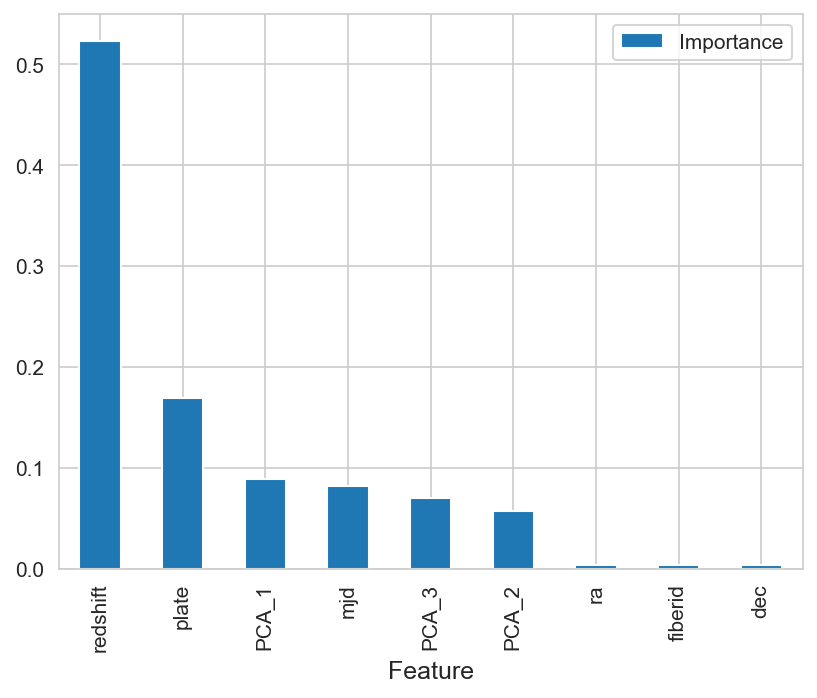

In [43]:
importance.plot.bar()
plt.savefig('importance.png')

In [44]:
scaler = MinMaxScaler()
sdss_df_fe.drop(['fiberid', 'ra', 'dec'], axis=1, inplace=True)

In [45]:
sdss_df_fe['class'] = y_encoded
sdss_df_fe.describe()

,class,redshift,plate,mjd,PCA_1,PCA_2,PCA_3
count,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,1.000000e+04,1.000000e+04
mean,0.915400,0.143726,1460.986400,52943.533300,-9.237056e-16,-3.240785e-15,-1.986411e-15
std,0.952856,0.388774,1788.778371,1511.150651,2.222472e+00,6.920866e-01,1.583135e-01
min,0.000000,-0.004136,266.000000,51578.000000,-9.640301e+00,-2.018363e+00,-1.787185e+00
25%,0.000000,0.000081,301.000000,51900.000000,-1.367704e+00,-5.081577e-01,-8.775930e-02
50%,1.000000,0.042591,441.000000,51997.000000,6.048314e-02,-3.327989e-02,-6.390920e-04
75%,2.000000,0.092579,2559.000000,54468.000000,1.417466e+00,4.500008e-01,8.986401e-02
max,2.000000,5.353854,8410.000000,57481.000000,1.143611e+01,7.225887e+00,2.138851e+00


In [46]:
sdss = scaler.fit_transform(sdss_df_fe.drop('class', axis = 1))
X_train, X_test, y_train, y_test = train_test_split(sdss, sdss_df_fe['class'], test_size=0.2)

In [47]:
# Naive Bayes
gnb = GaussianNB()
scores = cross_val_score(gnb, X_train, y_train, cv=10, scoring = "accuracy")
print("Scores:", scores*100)
print("Mean:", scores.mean()*100)

Scores: [98.    97.25  98.25  97.    96.875 98.    97.5   99.    98.125 97.625]
Mean: 97.7625


In [48]:
# Support Vector Machine
svc = SVC(C = best_c, kernel = best_k)
scores = cross_val_score(svc, X_train, y_train, cv=10, scoring = "accuracy")
print("Scores:", scores*100)
print("Mean:", scores.mean()*100)

Scores: [99.25  99.375 99.125 98.625 99.    98.75  98.25  98.875 99.375 99.   ]
Mean: 98.96249999999999


In [49]:
# XGBoost
xgb = XGBClassifier(n_estimators = n_xgb_best)
scores = cross_val_score(xgb, X_train, y_train, cv=10, scoring = "accuracy")
print("Scores:", scores*100)
print("Mean:", scores.mean()*100)

Scores: [99.5   99.5   99.75  99.25  99.125 99.125 99.25  99.5   99.125 99.625]
Mean: 99.375


In [50]:
# Random Forest
rfc = RandomForestClassifier(n_estimators = n_rfc_best)
scores = cross_val_score(rfc, X_train, y_train, cv=10, scoring = "accuracy")
print("Scores:", scores* 100)
print("Mean:", scores.mean()*100)

Scores: [99.375 99.5   99.25  98.875 99.25  99.125 99.    99.375 99.125 99.25 ]
Mean: 99.2125


In [51]:
unique, counts = np.unique(sdss_df_fe['class'], return_counts=True)
dict(zip(unique, counts))

{0: 4998, 1: 850, 2: 4152}

In [52]:
predictions = cross_val_predict(xgb, sdss_df_fe.drop('class', axis=1), sdss_df_fe['class'], cv=3)
confusion_matrix(sdss_df_fe['class'], predictions)

array([[4964,   26,    8],
       [  29,  820,    1],
       [   6,    0, 4146]], dtype=int64)

In [53]:
print("Precision:", precision_score(sdss_df_fe['class'], predictions, average='micro'))
print("Recall:",recall_score(sdss_df_fe['class'], predictions, average='micro'))

Precision: 0.993
Recall: 0.993


In [54]:
print("F1-Score:", f1_score(sdss_df_fe['class'], predictions, average='micro'))

F1-Score: 0.993
